### Try-it 9.2: Predicting Wages

This activity is meant to summarize your work with regularized regression models.  You will use your earlier work with data preparation and pipelines together with what you've learned with grid searches to determine an optimal model.  In addition to the prior strategies, this example is an excellent opportunity to utilize the `TransformedTargetRegressor` estimator in scikitlearn.

### The Data

This dataset is loaded from the openml resource library.  Originally from census data, the data contains wage and demographic information on 534 individuals. From the dataset documentation [here](https://www.openml.org/d/534)

```
The Current Population Survey (CPS) is used to supplement census information between census years. These data consist of a random sample of 534 persons from the CPS, with information on wages and other characteristics of the workers, including sex, number of years of education, years of work experience, occupational status, region of residence and union membership. 
```

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
wages = fetch_openml(data_id=534, as_frame=True).frame

In [3]:
wages.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,5.10,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,4.95,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,6.67,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,4.00,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,7.50,35,White,Other,Other,Married


#### Task

Build regression models to predict `WAGE`.  Incorporate the categorical features and transform the target using a logarithm.  Build `Ridge` models and consider some different amounts of regularization.  

After fitting your model, interpret the model and try to understand what features led to higher wages.  Consider using `permutation_importance` that you encountered in module 8.  Discuss your findings in the class forum.

For an in depth example discussing the perils of interpreting the coefficients see the example in scikitlearn examples [here](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html).

In [20]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn as sns

In [5]:
wages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    int64   
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    int64   
 4   UNION       534 non-null    category
 5   WAGE        534 non-null    float64 
 6   AGE         534 non-null    int64   
 7   RACE        534 non-null    category
 8   OCCUPATION  534 non-null    category
 9   SECTOR      534 non-null    category
 10  MARR        534 non-null    category
dtypes: category(7), float64(1), int64(3)
memory usage: 21.4 KB


let's begin checking whether this data set has missing values?

In [6]:
wages.isnull().sum()

EDUCATION     0
SOUTH         0
SEX           0
EXPERIENCE    0
UNION         0
WAGE          0
AGE           0
RACE          0
OCCUPATION    0
SECTOR        0
MARR          0
dtype: int64

great no missing values, what about outliers?

also, since there are 7 categorical features, we will be selecting numerical features for outlier analysis

In [7]:
# Select only numeric columns for IQR calculation
numeric_wages = wages.select_dtypes(include=['number'])

Q1 = numeric_wages.quantile(0.25)
Q3 = numeric_wages.quantile(0.75)
IQR = Q3 - Q1

# Identify outliers in the numeric columns
outliers = ((numeric_wages < (Q1 - 1.5 * IQR)) | (numeric_wages > (Q3 + 1.5 * IQR))).any(axis=1)
outlier_data = wages[outliers]
outlier_data

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
16,7,yes,male,44,not_member,8.00,57,White,Other,Other,Married
17,12,no,male,26,member,22.20,44,White,Other,Manufacturing,Married
19,12,no,male,33,not_member,20.55,51,White,Other,Other,Married
21,7,no,male,42,member,7.00,55,Other,Other,Manufacturing,Married
25,6,yes,male,45,not_member,5.75,57,White,Other,Manufacturing,Married
45,7,yes,female,15,not_member,6.00,28,White,Other,Manufacturing,Married
62,3,yes,male,55,not_member,7.00,64,Hispanic,Other,Manufacturing,Married
75,6,no,female,43,member,3.00,55,Hispanic,Other,Manufacturing,Married
106,14,no,male,21,member,26.00,41,White,Other,Other,Married
107,5,yes,male,44,not_member,14.00,55,White,Other,Construction,Married


so what do we do with these outliers?

here are some considerations and guildines I came up with:
    1. Do Nothing: If outliers are genuine and reflect the data's natural variation, keep them.

    2. Remove: If they're errors or very extreme, removing them might improve model accuracy.

    3. Transform: Applying transformations (log, square root) can reduce the impact of outliers.

    4. Impute: Replace outliers with statistics like median or mean, though this can bias your data.

    5. Model Choice: Use models less sensitive to outliers, like tree-based methods.

With these being said, I would use do nothing in this case because I want an inclusion of all kind of wage. Say if we live in America, I still want to include billionaires wage as well. Also, there only 36 entries out of 534 entries, which is relatively small, but since we are using simple linear regression models that are sensitive to outliers and not robust like Random Forest or Gradient Boosting Machines. So we have to monitor the prediction result closely and interpret accordingly to the outliers represent in the training data!

# EDA

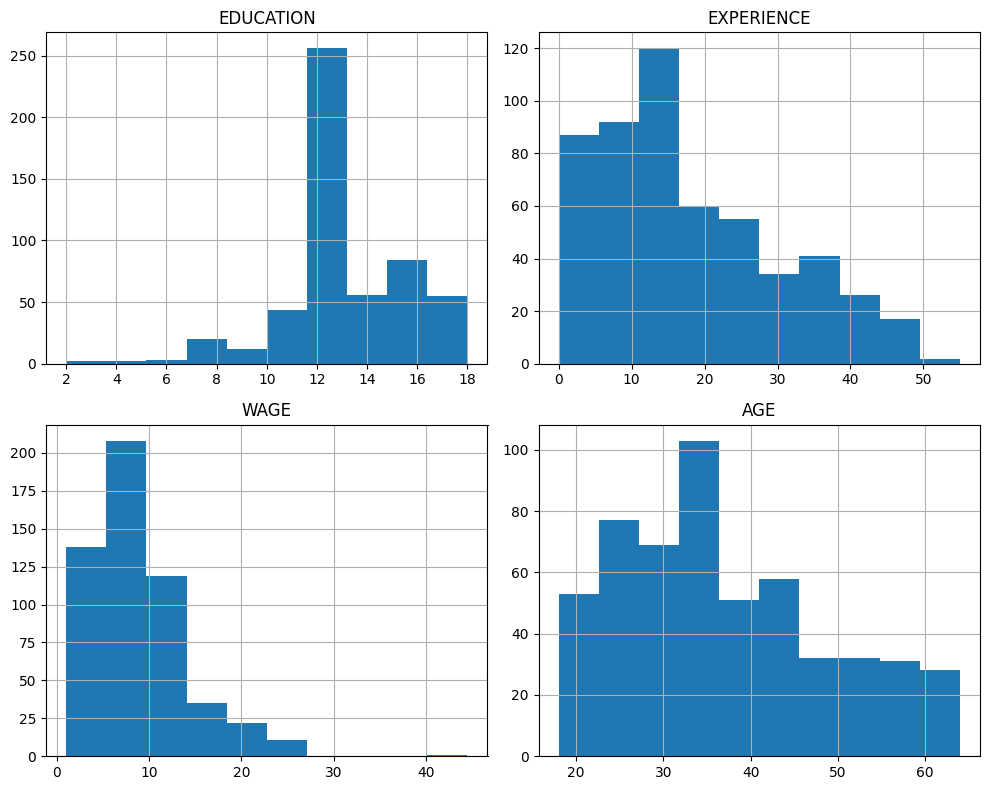

In [18]:
# Histograms for numerical features
wages.hist(bins=10, figsize=(10, 8))
plt.tight_layout()
plt.show()


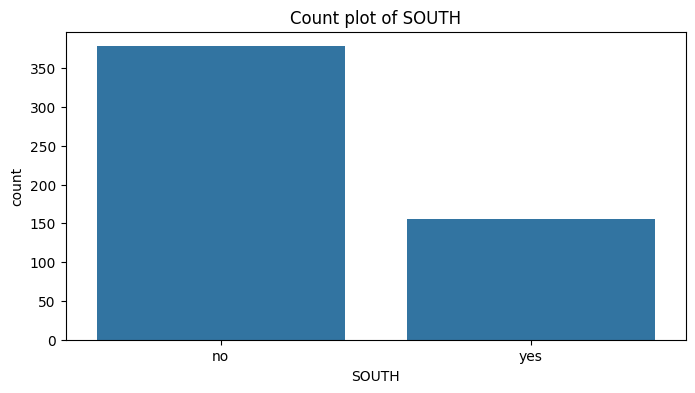

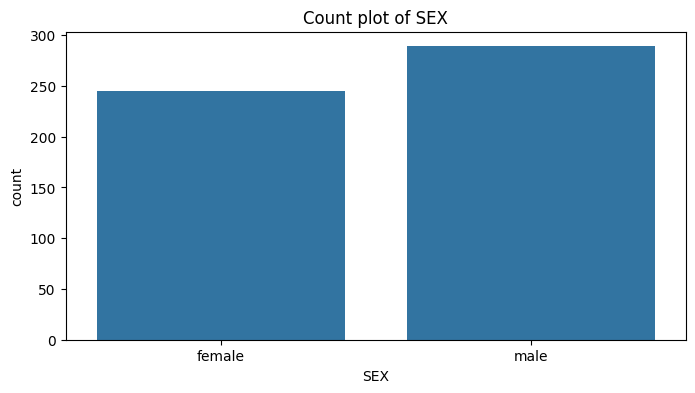

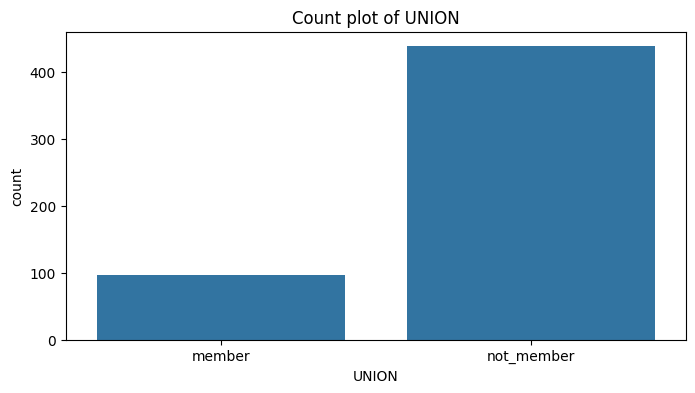

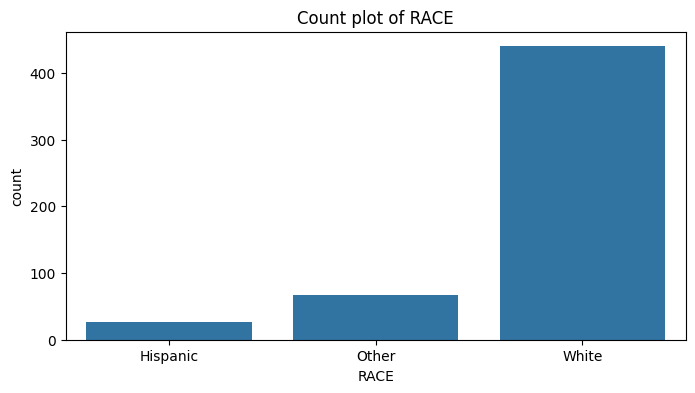

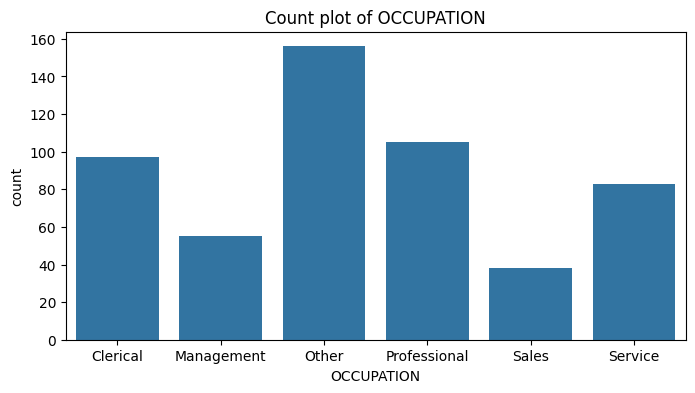

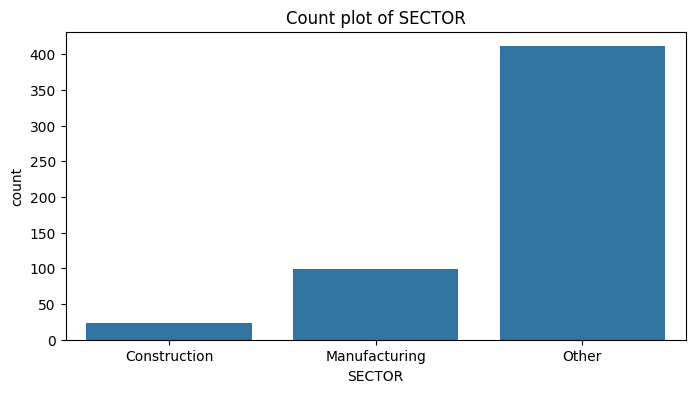

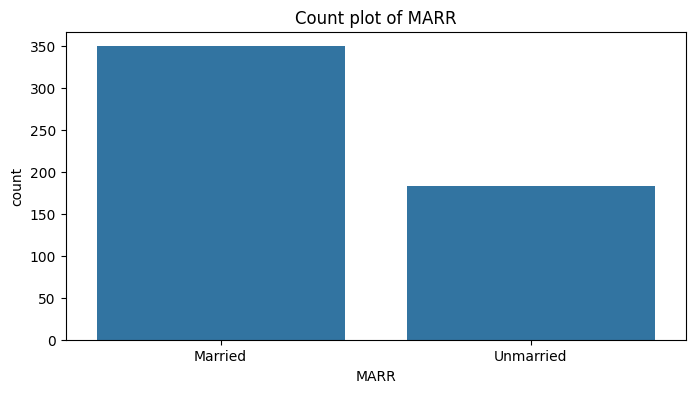

In [22]:
# Count plots for categorical features
categorical_features = ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR']
for col in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=wages, x=col)
    plt.title(f'Count plot of {col}')
    plt.show()


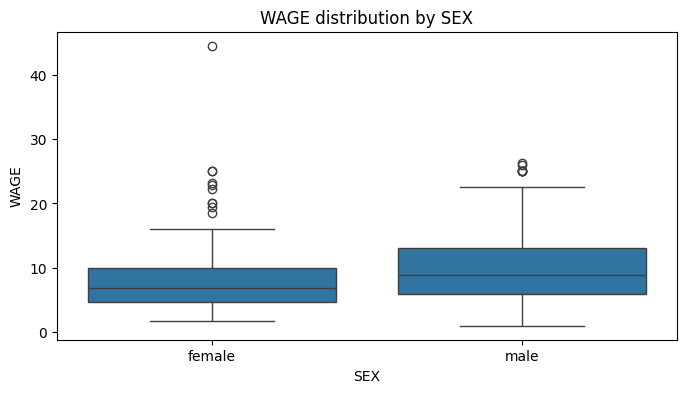

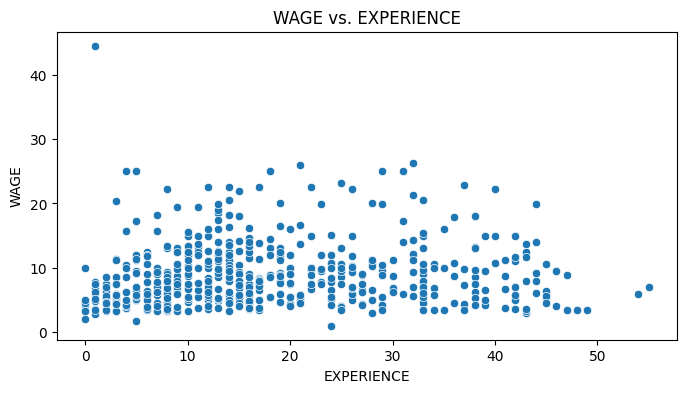

In [23]:
# Boxplot for WAGE distribution across different SEX
plt.figure(figsize=(8, 4))
sns.boxplot(data=wages, x='SEX', y='WAGE')
plt.title('WAGE distribution by SEX')
plt.show()

# Scatter plot of WAGE against EXPERIENCE
plt.figure(figsize=(8, 4))
sns.scatterplot(data=wages, x='EXPERIENCE', y='WAGE')
plt.title('WAGE vs. EXPERIENCE')
plt.show()


wage has linear relationship with experience and men make a little bit more money than women on average

# Data Prep and Model Compararison

I have created a libraries that take data, process it (StandarScaler(), ColumnTransformer() both categorical adn numerical), build a pipeline with the corresponding model and feature selector techniques, it also perform different CV techniques and lastly fit the model and compute the average MSE. Please enjoy the magic...

JK it is just all the material we learn in this module haha

In [8]:
import sys
sys.path.append(r'c:\Users\Duy Nguyen\Downloads\UCBerkleyML-AI-TryIts\module 9\9.3')


In [9]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from ML_AI_DuyNguyen.model_selection import FeatureSelector, ModelEvaluator, ModelTrainer

In [10]:
y = wages['WAGE']
X = wages.drop('WAGE', axis=1)

numeric_features = ['EDUCATION', 'EXPERIENCE', 'AGE']  
categorical_features = ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR']

In [11]:
cv_strategies = {
    "KFold": {"n_splits": 5},
    "LOO": {},
    "Holdout": {"test_size": 0.2, "random_state": 42}  # Example configuration
}


#### Looping Through all the possible CVs on each model and feature selection!
- We are implementing grid search cv manually and without actually using GridSearchCV()
- In this model_selection module, we first build a pipeline that ColumnsTrasform numeric and categorical features to deal with categorical feature for training
- Then we pass the feature selector method and which model for fitting into the pipeline.
- After we set up the pipeline in ModelTrainer module, we pass the X and y into the ModelEvaluator to split the training and testing data using our CVs technique.
- Then we pass the split data to train the pipeline
- After we get our first trained model, we predict and compute the average test MSE
    - Remember that the reason we calculate the mean because the each CV technique has many folds. For example, K fold, if you choose K = 5, you have 5 folds so we take the average of 5.
    - While LOOCV will have the number of fold base on the number of rows of the data set so that is take longer to compute for LOOCV


In [16]:
# Define models and their hyperparameters
models_and_hyperparams = {
    Ridge: {'alphas': [0.01, 0.1, 1.0, 10.0, 100.0]},
    Lasso: {'alphas': [0.01, 0.1, 1.0, 10.0, 100.0]}
}

feature_selection_strategies = ['SFS', 'RFE', 'RidgeImportance']

model_trainers = []

# Feature selector initialization
feature_selector = FeatureSelector(n_features_to_select=5)

for model_cls, hyperparams in models_and_hyperparams.items():
    for strategy in feature_selection_strategies:
        for alpha in hyperparams['alphas']:
            model = model_cls(alpha=alpha)  # Instantiate the model with the current alpha
            trainer = ModelTrainer(model, feature_selector=feature_selector, selection_strategy=strategy, numeric_features=numeric_features, categorical_features=categorical_features)
            model_trainers.append(trainer)


# Note: LinearRegression doesn't have a hyperparameter like alpha to vary in this context
linear_trainer_RFE = ModelTrainer(LinearRegression(), feature_selector=feature_selector, selection_strategy='RFE', numeric_features=numeric_features, categorical_features=categorical_features)
model_trainers.append(linear_trainer_RFE)

linear_trainer_SFS = ModelTrainer(LinearRegression(), feature_selector=feature_selector, selection_strategy='SFS', numeric_features=numeric_features, categorical_features=categorical_features)
model_trainers.append(linear_trainer_SFS)

# Define your CV strategies
cv_strategies = {
    "KFold": {"n_splits": 5},
    "LOO": {},
    "Holdout": {"test_size": 0.2, "random_state": 42}
}


In [17]:
# Assuming ModelEvaluator is defined as before
model_evaluator = ModelEvaluator(model_trainers=model_trainers, cv_strategies=cv_strategies)

results = model_evaluator.evaluate(X, y)

('KFold', 'Ridge_SFS'): Avg MSE = 22.938327014441533
('KFold', 'Ridge_RFE'): Avg MSE = 23.24637321419215
('KFold', 'Ridge_RidgeImportance'): Avg MSE = 23.570344567622573
('KFold', 'Lasso_SFS'): Avg MSE = 25.716429767292603
('KFold', 'Lasso_RFE'): Avg MSE = 25.836296276685797
('KFold', 'Lasso_RidgeImportance'): Avg MSE = 26.060582603214172
('KFold', 'LinearRegression_RFE'): Avg MSE = 23.398033193573173
('KFold', 'LinearRegression_SFS'): Avg MSE = 23.159317177007583
('LOO', 'Ridge_SFS'): Avg MSE = 20.434196880153124
('LOO', 'Ridge_RFE'): Avg MSE = 22.269655784149247
('LOO', 'Ridge_RidgeImportance'): Avg MSE = 21.598413523281337
('LOO', 'Lasso_SFS'): Avg MSE = 23.438718785051996
('LOO', 'Lasso_RFE'): Avg MSE = 24.469145493949604
('LOO', 'Lasso_RidgeImportance'): Avg MSE = 23.931495015552223
('LOO', 'LinearRegression_RFE'): Avg MSE = 22.019583347290794
('LOO', 'LinearRegression_SFS'): Avg MSE = 20.421999464254686
('Holdout', 'Ridge_SFS'): Avg MSE = 21.168060614664505
('Holdout', 'Ridge_RFE

{('KFold', 'Ridge_SFS'): [17.972372072865692,
  17.967805785213123,
  17.92437814948128,
  17.647942073552038,
  17.662152402858972,
  35.79491726766729,
  35.7906124115059,
  35.74890049969574,
  35.44051889024599,
  35.50025118539683,
  11.510088668715653,
  11.510228419904536,
  11.511718039579966,
  11.534498132013626,
  11.987611140631511,
  15.587352843549338,
  15.58559999450024,
  15.568651346253512,
  15.44656195741763,
  15.594928011009898,
  34.92873803580715,
  34.91127815193862,
  34.74287327602152,
  33.52563121744541,
  32.062565387766846],
 ('KFold', 'Ridge_RFE'): [19.668246019816152,
  19.66363564235365,
  19.61988408968801,
  19.348396912752925,
  19.27523264368893,
  40.37174376222034,
  40.36211116081468,
  40.26817321063461,
  39.52340264956989,
  37.89365422808674,
  10.80733698814095,
  10.808560724465972,
  10.822221823312189,
  11.029084460461519,
  12.33844080606168,
  13.63350737993334,
  13.634443701661024,
  13.644222591353179,
  13.76381935006541,
  14.797

# Disclaimer: run the grid search manually took around 2.45 hours (147 mins) so be PATIENT

Now that we have all the model, what is the best model out of these 27 models:

In [26]:
# Initialize a dictionary to store the average MSE for each model configuration
avg_mse_scores = {}

# Iterate through the results to calculate the average MSE
for key, scores in results.items():
    avg_mse = np.mean(scores)
    avg_mse_scores[key] = avg_mse
    print(f"{key}: Avg MSE = {avg_mse}")

# Identify the model configuration with the lowest average MSE
lowest_avg_mse_key = min(avg_mse_scores, key=avg_mse_scores.get)
lowest_avg_mse_value = avg_mse_scores[lowest_avg_mse_key]

print(f"\nModel with the lowest Avg MSE: {lowest_avg_mse_key} => Avg MSE = {lowest_avg_mse_value}")


('KFold', 'Ridge_RFE_alpha1.0'): Avg MSE = 28.951802636551104
('LOO', 'Ridge_RFE_alpha1.0'): Avg MSE = 22.369498965288724
('Holdout', 'Ridge_RFE_alpha1.0'): Avg MSE = 23.898849258499627

Model with the lowest Avg MSE: ('LOO', 'Ridge_RFE_alpha1.0') => Avg MSE = 22.369498965288724


### Simple hyperparameters Example

In [25]:
feature_selector = FeatureSelector(n_features_to_select=2)

ridge_RFE_1 = ModelTrainer(Ridge(alpha=1.0), feature_selector=feature_selector, selection_strategy='RFE', numeric_features=numeric_features, categorical_features=categorical_features)
model_evaluator = ModelEvaluator(model_trainers=[ridge_RFE_1], cv_strategies=cv_strategies)

results = model_evaluator.evaluate(X, y)

('KFold', 'Ridge_RFE_alpha1.0'): Avg MSE = 28.951802636551104
('LOO', 'Ridge_RFE_alpha1.0'): Avg MSE = 22.369498965288724
('Holdout', 'Ridge_RFE_alpha1.0'): Avg MSE = 23.898849258499627


now we are expecting 3 means from each CV technique

the lowest we get is 
- Model with the lowest Avg MSE: ('LOO', 'Ridge_RFE_alpha1.0') => Avg MSE = 22.369498965288724
